In [1]:
pip install rasterio fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 51.0 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.features import geometry_mask
from collections import defaultdict
import numpy as np

                                            geometry
0  POLYGON ((628638 3061134, 628638 3061143, 6286...
1  POLYGON ((628647 3061134, 628647 3061143, 6286...
2  POLYGON ((628656 3061134, 628656 3061143, 6286...
3  POLYGON ((628665 3061134, 628665 3061143, 6286...
4  POLYGON ((628674 3061134, 628674 3061143, 6286...


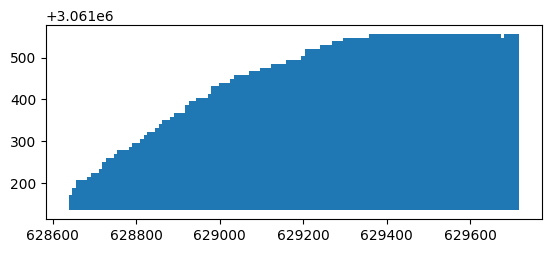

In [3]:

data = gpd.read_file('2022_cc_driscoll_grid_9m_sorghum.shp')
print(data.head())
data.plot()
plt.show()

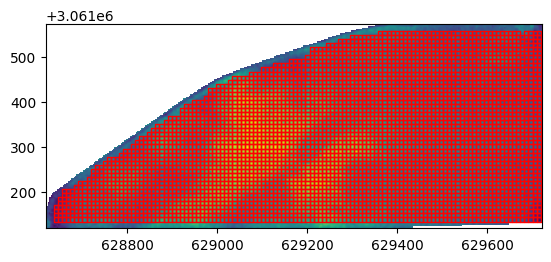

In [4]:
with rasterio.open('20190309.tif') as src:
    fig, ax = plt.subplots()
    show(src, ax=ax)
    shapefile_data = gpd.read_file('2022_cc_driscoll_grid_9m_sorghum.shp')
    shapefile_data.plot(ax=ax, facecolor='none', edgecolor='red')

plt.show()

In [5]:
with fiona.open("2022_cc_driscoll_grid_9m_sorghum.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]


with rasterio.open("20190309.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})


with rasterio.open("/content/image_tif", "w", **out_meta) as dest:
    dest.write(out_image)

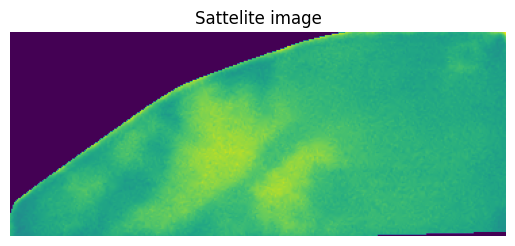

In [6]:
# Open the masked TIFF file
with rasterio.open("20190309.tif") as src:
    # Read the image data
    img = src.read(4)

# Display the image using matplotlib
plt.imshow(img, cmap='viridis')
plt.title('Sattelite image')
plt.axis('off')
plt.show()

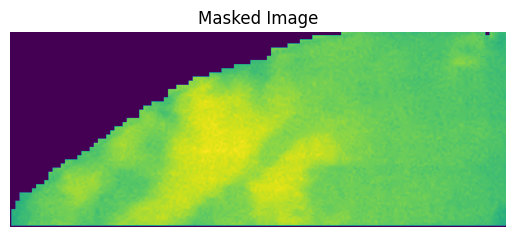

In [7]:


# Open the masked TIFF file
with rasterio.open("/content/image_tif") as src:
    # Read the image data
    img = src.read(1)

# Display the image using matplotlib
plt.imshow(img, cmap='viridis')
plt.title('Masked Image')
plt.axis('off')
plt.show()

In [8]:
# Open the masked TIFF file
with rasterio.open("/content/image_tif") as src:
    # Read the image data
    img = src.read(1)  # Read the first band

    # Print the shape of the image
    print(f"Image shape: {img.shape}")  # (height, width)


Image shape: (142, 361)


Unique FID values in raster: [   0    1    2 ... 4281 4282 4283]


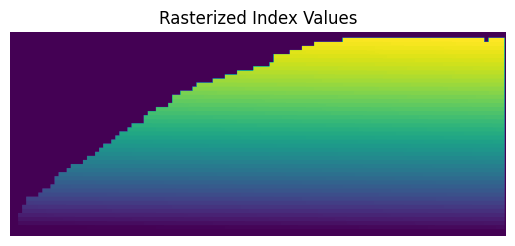

In [9]:

from rasterio.features import rasterize
with fiona.open("2022_cc_driscoll_grid_9m_sorghum.shp", "r") as shapefile:
    shapes = [(feature["geometry"], int(feature["id"])) for feature in shapefile]


with rasterio.open("20190309.tif") as src:
    out_shape = (src.height, src.width)
    transform = src.transform
    rasterized_indices = rasterize(
        shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,  # Background value for areas not covered by any shape
        dtype=rasterio.uint16  # Assuming FID values fit into uint16
    )


unique_indices = np.unique(rasterized_indices)
print("Unique FID values in raster:", unique_indices)
plt.imshow(rasterized_indices, cmap='viridis')
plt.title('Rasterized Index Values')
plt.axis('off')
plt.show()

In [10]:
len(unique_indices)

4284

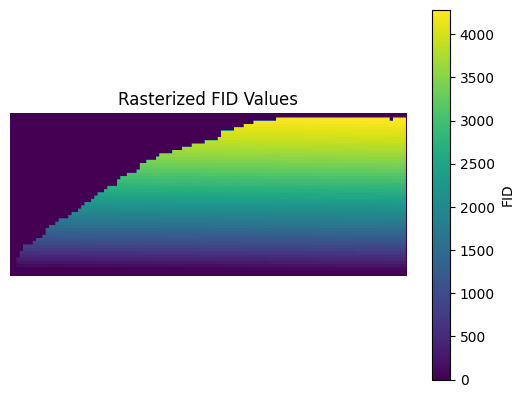

In [11]:
import matplotlib.pyplot as plt

# Display the rasterized indices
plt.imshow(rasterized_indices, cmap='viridis')
plt.colorbar(label='FID')
plt.title('Rasterized FID Values')
plt.axis('off')
plt.show()

In [12]:
import geopandas as gpd

# Load the shapefile
shapefile = gpd.read_file('2022_cc_driscoll_grid_9m_sorghum.shp')

# Print the shape (rows, columns)
print(f"Shapefile shape: {shapefile.shape}")

Shapefile shape: (4284, 1)


In [13]:
print("Columns in shapefile:", shapefile.columns)



Columns in shapefile: Index(['geometry'], dtype='object')


In [14]:
import rasterio

# Open the TIFF file
with rasterio.open('image_tif') as src:
    # Retrieve dimensions
    width = src.width
    height = src.height

    # Calculate total number of pixels
    total_pixels = width * height

print(f"Width: {width}, Height: {height}")
print(f"Total number of pixels: {total_pixels}")

Width: 361, Height: 142
Total number of pixels: 51262


In [15]:



# Load the shapefile
shapefile = gpd.read_file('2022_cc_driscoll_grid_9m_sorghum.shp')

# Open the raster image
with rasterio.open('image_tif') as src:
    image = src.read(1)  # Read the first band
    transform = src.transform

# Initialize a dictionary to store pixel counts for each fid
pixel_counts = {fid: 0 for fid in shapefile.index}

# Iterate over each geometry in the shapefile
for index, row in shapefile.iterrows():
    geometry = [row['geometry']]

    # Create a mask for the current geometry
    mask = geometry_mask(geometry, transform=transform, invert=True,
                         out_shape=(src.height, src.width))

    # Count the number of True values in the mask (i.e., pixels within the geometry)
    pixel_counts[index] = mask.sum()

print(pixel_counts)

{0: 9, 1: 9, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9, 10: 9, 11: 9, 12: 9, 13: 9, 14: 9, 15: 9, 16: 9, 17: 9, 18: 9, 19: 9, 20: 9, 21: 9, 22: 9, 23: 9, 24: 9, 25: 9, 26: 9, 27: 9, 28: 9, 29: 9, 30: 9, 31: 9, 32: 9, 33: 9, 34: 9, 35: 9, 36: 9, 37: 9, 38: 9, 39: 9, 40: 9, 41: 9, 42: 9, 43: 9, 44: 9, 45: 9, 46: 9, 47: 9, 48: 9, 49: 9, 50: 9, 51: 9, 52: 9, 53: 9, 54: 9, 55: 9, 56: 9, 57: 9, 58: 9, 59: 9, 60: 9, 61: 9, 62: 9, 63: 9, 64: 9, 65: 9, 66: 9, 67: 9, 68: 9, 69: 9, 70: 9, 71: 9, 72: 9, 73: 9, 74: 9, 75: 9, 76: 9, 77: 9, 78: 9, 79: 9, 80: 9, 81: 9, 82: 9, 83: 9, 84: 9, 85: 9, 86: 9, 87: 9, 88: 9, 89: 9, 90: 9, 91: 9, 92: 9, 93: 9, 94: 9, 95: 9, 96: 9, 97: 9, 98: 9, 99: 9, 100: 9, 101: 9, 102: 9, 103: 9, 104: 9, 105: 9, 106: 9, 107: 9, 108: 9, 109: 9, 110: 9, 111: 9, 112: 9, 113: 9, 114: 9, 115: 9, 116: 9, 117: 9, 118: 9, 119: 9, 120: 9, 121: 9, 122: 9, 123: 9, 124: 9, 125: 9, 126: 9, 127: 9, 128: 9, 129: 9, 130: 9, 131: 9, 132: 9, 133: 9, 134: 9, 135: 9, 136: 9, 137: 9, 138: 

In [16]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask

# Load the shapefile
shapefile = gpd.read_file('2022_cc_driscoll_grid_9m_sorghum.shp')

# Open the raster image
with rasterio.open('image_tif') as src:
    nir_band = src.read(4)  #  NIR is band 4
    red_band = src.read(3)  #  Red is band 3
    green_band = src.read(2)  #  Green is band 2
    transform = src.transform

# Calculate NDVI and GCI for each pixel safely
ndvi = np.where(
    (nir_band + red_band) != 0,
    (nir_band - red_band) / (nir_band + red_band),
    np.nan
)

gci = np.where(
    green_band != 0,
    (nir_band / green_band) - 1,
    np.nan
)

# Initialize dictionaries to store NDVI and GCI values for each index
ndvi_values = {fid: [] for fid in shapefile.index}
gci_values = {fid: [] for fid in shapefile.index}

# Iterate over each geometry in the shapefile
for index, row in shapefile.iterrows():
    geometry = [row['geometry']]

    # Create a mask for the current geometry
    mask = geometry_mask(geometry, transform=transform, invert=True,
                         out_shape=(src.height, src.width))

    # Append NDVI and GCI values for pixels within the geometry
    ndvi_values[index] = ndvi[mask].tolist()
    gci_values[index] = gci[mask].tolist()

# Compute average NDVI and GCI values for each index
average_ndvi = {index: np.nanmean(values) if values else np.nan for index, values in ndvi_values.items()}
average_gci = {index: np.nanmean(values) if values else np.nan for index, values in gci_values.items()}

<ipython-input-16-dd8a2b1d5120>:19: RuntimeWarning: invalid value encountered in divide
  (nir_band - red_band) / (nir_band + red_band),
<ipython-input-16-dd8a2b1d5120>:25: RuntimeWarning: invalid value encountered in divide
  (nir_band / green_band) - 1,


In [17]:
import pandas as pd
df = pd.DataFrame({
    'Index': list(average_ndvi.keys()),
    'NDVI': list(average_ndvi.values()),
    'GCI': list(average_gci.values())
})


In [18]:
df.shape

(4284, 3)

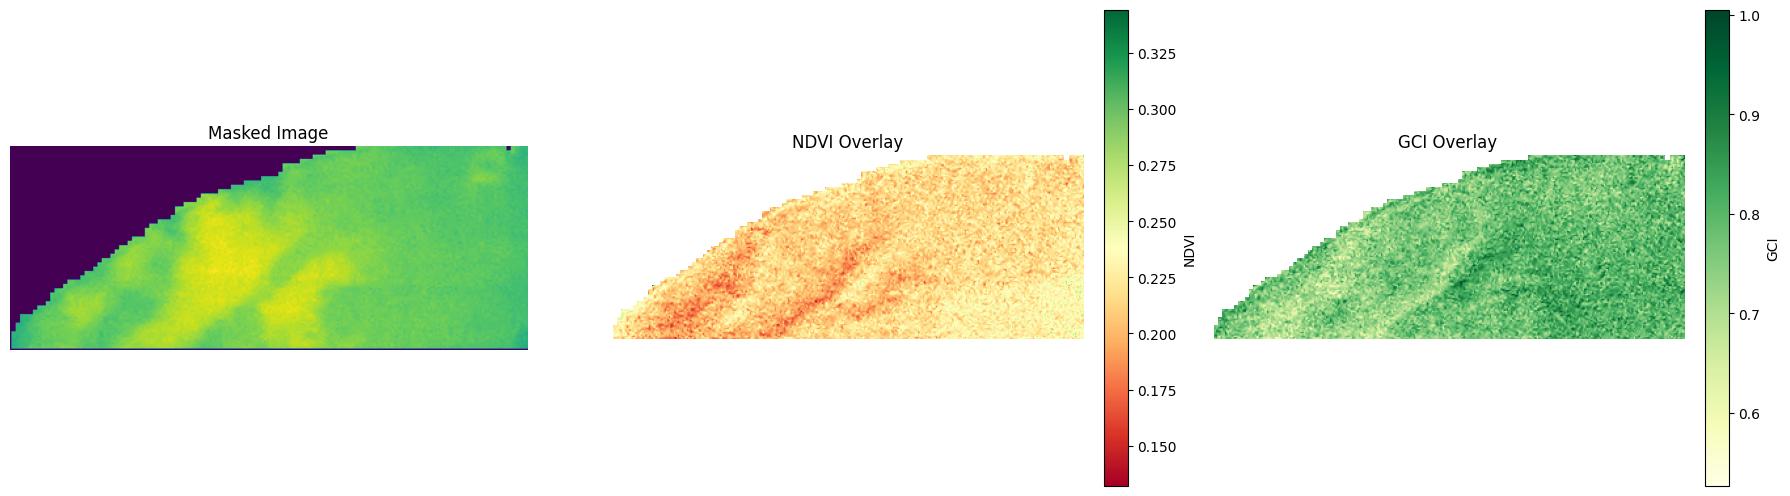

In [19]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
with rasterio.open("/content/image_tif") as src:
    img = src.read(1)
plt.imshow(img, cmap='viridis')
plt.title('Masked Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI', fraction=0.046, pad=0.04)
plt.title('NDVI Overlay')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gci, cmap='YlGn')
plt.colorbar(label='GCI', fraction=0.046, pad=0.04)
plt.title('GCI Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import rasterio
from rasterio.features import geometry_mask


index_to_inspect = 0  # Change this to the desired index
geometry = [shapefile.loc[index_to_inspect, 'geometry']]

with rasterio.open('image_tif') as src:
    transform = src.transform
    height, width = src.height, src.width

    # Create a mask for the specified geometry
    mask = geometry_mask(geometry, transform=transform, invert=True,
                         out_shape=(height, width))
pixel_indices = np.argwhere(mask)

# Print pixel indices
print(f'Pixel indices for Index {index_to_inspect}:')
for row, col in pixel_indices:
    print(f'Row: {row}, Column: {col}')

Pixel indices for Index 0:
Row: 138, Column: 1
Row: 138, Column: 2
Row: 138, Column: 3
Row: 139, Column: 1
Row: 139, Column: 2
Row: 139, Column: 3
Row: 140, Column: 1
Row: 140, Column: 2
Row: 140, Column: 3


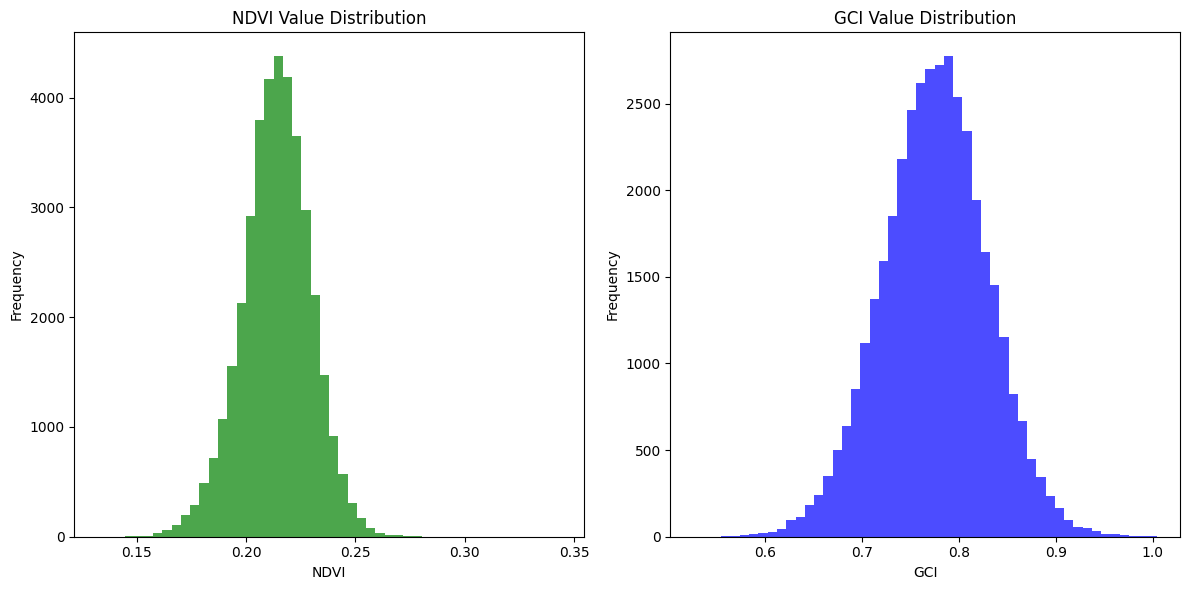

In [22]:
ndvi_flat = ndvi[~np.isnan(ndvi)].flatten()
gci_flat = gci[~np.isnan(gci)].flatten()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(ndvi_flat, bins=50, color='green', alpha=0.7)
plt.title('NDVI Value Distribution')
plt.xlabel('NDVI')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(gci_flat, bins=50, color='blue', alpha=0.7)
plt.title('GCI Value Distribution')
plt.xlabel('GCI')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

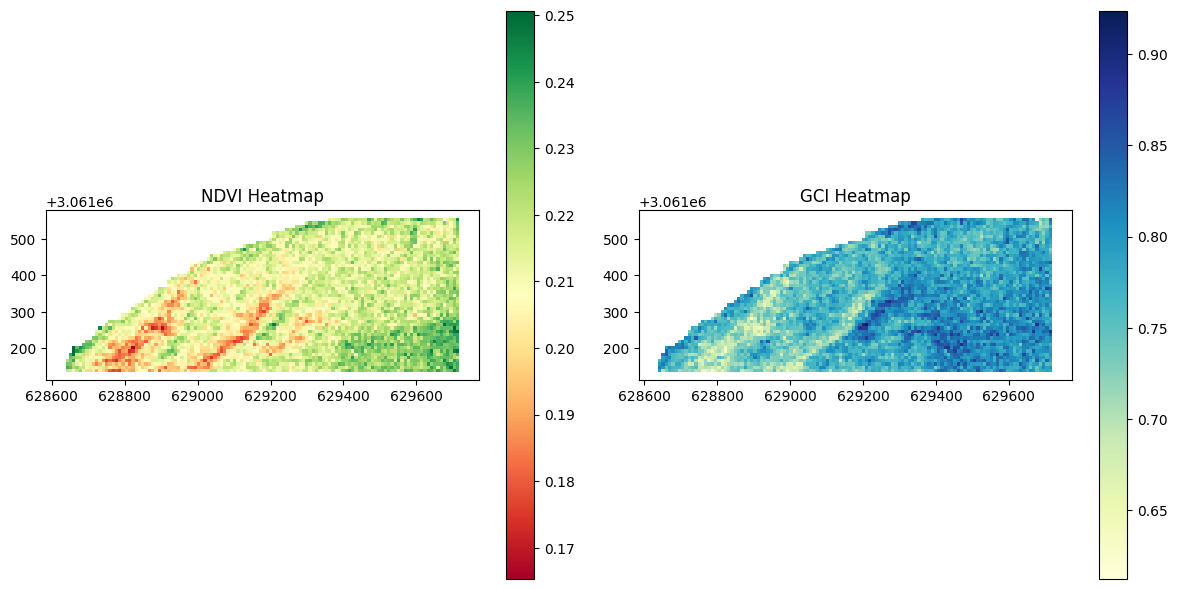

In [35]:

gdf = gpd.GeoDataFrame({
    'geometry': shapefile['geometry'],
    'NDVI': [average_ndvi[index] for index in shapefile.index],
    'GCI': [average_gci[index] for index in shapefile.index]
})


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
gdf.plot(column='NDVI', cmap='RdYlGn', legend=True, ax=ax[0])
ax[0].set_title('NDVI Heatmap')

gdf.plot(column='GCI', cmap='YlGnBu', legend=True, ax=ax[1])
ax[1].set_title('GCI Heatmap')

plt.tight_layout()
plt.show()